<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch
## Main_RandomTic_Discrete_AVDataset_Dow30_Daily
Network with 128 neutrons and 2 layers

# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Check Additional Packages](#1.1)
    * [2.2. Import Packages](#1.2)
    * [2.3. Create Folders & Relevant Configurations¶](#1.3)
* [3. Download Data](#2)
* [4. Preprocess fundamental data](#3)        
    * [4.1. Import the financial data](#3.1)
    * [4.2. Specify items needed to calculate financial ratios](#3.2)
    * [4.3. Turn the final_ratios to daily basis](#3.3)
    * [4.4. Merge stock price data and ratios into one dataframe](#3.4)
    * [4.5. Finish data preparation](#3.5)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. Set up the training environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Train DRL Agent](#5)  
* [7.Backtest Our Strategy](#6)  
    * [7.1. BackTest with DJIA](#6.1)
    * [7.2. BackTest with Buy&Hold Strategy](#6.2)
* [8.Save & load model](#7)
    * [8.1. Save model](#7.1)
    * [8.2. Load model](#7.2)

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Alpha Vantage API. The data contains Open-High-Low-Close price and volume.


### If continuing the previous training, jump to [**this point**](#8.1)

<a id='1'></a>
# Part 2. Getting Started- Load Python Packages


<a id='1.1'></a>
## 2.1. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.2'></a>
## 2.2. Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
import math
from stable_baselines3.common.logger import configure

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.3'></a>
## 2.3. Create Folders & Relevant Configurations

In [3]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [4]:
from datetime import datetime
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = datetime.today().strftime('%Y-%m-%d')

# Load price data from csv file
tic_dir = './' + DATA_SAVE_DIR + '/sp500_price_daily.csv'
df = pd.read_csv(tic_dir,index_col=0)

If the data is available locally, we can skip downloading steps and jump directly to part [**4.5.Finish data preparation**](#3.5)

<a id='2'></a>
# Part 3. Download Price Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# Download data from YFinance
# tic_dir = './' + DATA_SAVE_DIR + '/sp500_ticker.csv'
# tic_list = pd.read_csv(tic_dir,index_col=0)
# SP_500_TICKER = np.array(tic_list.tic).tolist()
# df = YahooDownloader(start_date = TRAIN_START_DATE,
#                      end_date = TEST_END_DATE,
#                      ticker_list = SP_500_TICKER).fetch_data()

In [6]:
# df.head()

In [7]:
# df.tail()

In [8]:
# df.shape

In [9]:
# df.sort_values(['date','tic']).head()

In [10]:
# len(df.tic.unique())

In [11]:
# df.tic.value_counts()

<a id='3'></a>
# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Alpha Vantage
- Preprocess the dataset and calculate financial ratios
- Turn yearly ratio into daily basis

<a id='3.1'></a>
## 4.1 Import the financial data

#### Define configurations of the collecting data & download data via Alpha Vantage API

In [12]:
# import requests

# api_key = 'GZWRUSYXT18ZTR6C'
# features_cols = ['fiscalDateEnding','totalRevenue','costOfRevenue','sellingGeneralAndAdministrative','researchAndDevelopment','depreciation','interestExpense','totalCurrentLiabilities','incomeTaxExpense','netIncome','commonStockSharesOutstanding','cashAndCashEquivalentsAtCarryingValue','cashAndShortTermInvestments','operatingCashflow','totalLiabilities','inventory','currentNetReceivables','propertyPlantEquipment','capitalExpenditures','longTermInvestments','totalShareholderEquity','longTermDebt','retainedEarnings','dividendPayoutCommonStock','paymentsForRepurchaseOfCommonStock','treasuryStock','currentLongTermDebt']
# price_cols = ['open','high','low','close','volume']

Function to download fundamental data from financial reports by ticket

In [13]:
# def collect_fundamental(ticket):
#     # Download income statement
#     url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_is = r.json()

#     # Download balance sheet
#     url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_bs = r.json()

#     # Download cash flow
#     url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_cf = r.json()

#     df_is = pd.json_normalize(data_is['annualReports'])
#     df_bs = pd.json_normalize(data_bs['annualReports'])
#     df_cf = pd.json_normalize(data_cf['annualReports'])

#     merged_df = df_is.merge(df_bs).merge(df_cf)
#     merged_df['tic'] = ticket
#     merged_df = merged_df[['tic']+features_cols]
#     merged_df['fiscalDateEnding'] = pd.to_datetime(merged_df.fiscalDateEnding,format='mixed')

#     return merged_df

Function to download stock price by ticket

In [14]:
# def collect_price(ticket):
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={ticket}&apikey={api_key}'
#     r = requests.get(url)
#     data_monthly_price = r.json()

#     price_monthly = pd.DataFrame.from_dict(data_monthly_price['Monthly Time Series'], orient='index')
#     price_monthly.columns = price_cols
#     price_monthly['fiscalDateEnding'] = pd.to_datetime(price_monthly.index,format='mixed')
#     price_monthly.reset_index(inplace=True,drop=True)
#     price_monthly = price_monthly[['fiscalDateEnding','open','high','low','close','volume']]
#     return price_monthly

Function to merge monthly stock price into yearly fundamental data

In [15]:
# def merge_price_to_df(merged_df,price_monthly):
#     merged_df['year'] = merged_df.fiscalDateEnding.dt.year
#     merged_df['month'] = merged_df.fiscalDateEnding.dt.month
#     price_monthly['year'] = price_monthly.fiscalDateEnding.dt.year
#     price_monthly['month'] = price_monthly.fiscalDateEnding.dt.month
#     merged_final = pd.merge(merged_df,price_monthly,how="left",on=['year','month'])
#     merged_final.drop(columns=['year','month','fiscalDateEnding_y'],inplace=True)
#     merged_final = df_final.rename(columns={'fiscalDateEnding_x': 'date'})
#     merged_final['tic'] = ticket

#     merged_columns = [merged_final.columns[-1]]
#     for i in range(0,len(merged_final.columns)-1):
#         merged_columns.append(merged_final.columns[i])
#     merged_final = merged_final[merged_columns]
    
#     return merged_final

In [16]:
# download_tics = SP_500_TICKER[453:]
# print(download_tics)

In [17]:
# fund_data = pd.DataFrame()

# for ticket in download_tics:
#     df_fund = collect_fundamental(ticket)
#     fund_data = pd.concat([fund_data, df_fund], ignore_index=True)

In [18]:
# fund_data.to_csv('sp500_6.csv')

In [19]:
# Check dropped tickers which are not available data to download from Alpha Vantage

# tics_1 = pd.DataFrame()
# tics_2 = pd.DataFrame()
# tics_1['tic'] = df.tic.unique()
# tics_2['tic'] = fund_data.tic.unique()

# merged_df = tics_1.merge(tics_2, how='outer', indicator=True)
# unique_in_df = merged_df[merged_df['_merge'] == 'left_only']
# unique_in_df

#### Check reach download limitation

In [20]:
# url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=IBM&apikey=GZWRUSYXT18ZTR6C'
# r = requests.get(url)
# data_is = r.json()
# data_is

#### Load data from csv file

In [21]:
# fund_data = pd.read_csv('./' + DATA_SAVE_DIR + '/sp500_fundamental.csv',index_col=0)
# # fund_data = fund_data.rename(columns={'fiscalDateEnding_x':'date'})
# fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')
# fund_data

Select tickers in DJ index only.

In [22]:
# fund_data = fund_data[fund_data.tic.isin(DOW_30_TICKER)].reset_index(drop=True)
# fund_data.tic.nunique()

In [23]:
# # UTIL TOOL: merge yearly fundamental data to daily stock price

# start_date = df.iloc[0].date
# end_date = df.iloc[-1].date
# date_range = pd.date_range(start=start_date, end=end_date, freq='D')
# date_range = pd.DataFrame(date_range)
# date_range.columns = ['date']

# fund_data = fund_data.rename(columns={'fiscalDateEnding':'date'})
# fund_data['date'] = pd.to_datetime(fund_data.date,format='mixed')

# fund_data_with_price = pd.DataFrame()
# for ticket in fund_data.tic.unique():
#     price_by_ticket = df[df.tic == ticket]
#     price_by_ticket['date'] = pd.to_datetime(price_by_ticket['date'],format='mixed')
#     price_by_ticket = pd.merge(date_range,price_by_ticket,how='left')
#     price_by_ticket.bfill(inplace=True)
#     price_by_ticket = pd.merge(fund_data.loc[fund_data.tic==ticket],price_by_ticket,how='left',on=['date'])
#     price_by_ticket.drop(columns=['tic_y','day'],inplace=True,axis=0)
#     price_by_ticket = price_by_ticket.rename(columns={'tic_x':'tic'})
#     fund_data_with_price = pd.concat([fund_data_with_price, price_by_ticket], ignore_index=True)

#### Data cleaning ####
Refine the data before computing fundamental ratios

In [24]:
# print(fund_data.info(),'\n')
# print(fund_data.isna().sum())

The company with zero totalRevenue might cause problems for computing ratios while it is the denominator in some formulars.<br>
Deleting all tickers containing this issue is a good solution.

In [25]:
# zero_revenue_tics = fund_data[fund_data.totalRevenue == 0].tic.unique()
# fund_data = fund_data[~fund_data.tic.isin(zero_revenue_tics)]
# fund_data[fund_data.totalRevenue == 0]

While removing zero revenue data was neccessary, other columns with zero values might indicate some potential issues that require further investigations

In [26]:
# column_nan = fund_data.eq(0).any()
# column_nan

In [27]:
# fund_data = fund_data.fillna(0)
# for i in fund_data.columns:
#     print(i,'\n',fund_data[i].unique(),'\n')

## 4.2 Compute fundamental ratio

Define support functions before computing fundamental ratios

In [28]:
# # Define a function to count positive values within a window
# def count_positives(window):
#   return window[window > 0].count()

# def count_positives_window(data,k):
#     df = pd.DataFrame(data, columns=['values'])

#     # Create a new column with the adjusted positive count (using a shifted window)
#     df['positive_count'] = df['values'].rolling(window=k, min_periods=1).apply(count_positives)

#     # Set positive_count of the first k rows to positive_count of row k
#     df.loc[:k-1,'positive_count'] = df.loc[k-1].positive_count

#     return df

In [29]:
# # Define a function to min value within a window
# def get_min(window):
#   return window.min()

# def min_in_window(data,k):
#     df = pd.DataFrame(data, columns=['values'])

#     # Create a new column with the min in the window (using a shifted window)
#     df['min'] = df['values'].rolling(window=k, min_periods=1).apply(get_min)

#     return df

At this point, data and supporting functions are ready for computing fundamental ratios required

In [30]:
# def compute_fund_ratios(df_final):
#     pos_count_window = 10  # number of years to look back for count_positive_profit
#     min_ebit_window = 4  # number of years to look back for min_ebit
    
#     gross_income = df_final.totalRevenue - df_final.costOfRevenue
#     ebit = gross_income - df_final.sellingGeneralAndAdministrative
#     profit = ebit - df_final.interestExpense - df_final.incomeTaxExpense
#     market_equity = df_final.commonStockSharesOutstanding * df_final.close
#     market_asset = df_final.totalLiabilities + market_equity
    
#     # Gross profit margin
#     gross_profit_margin = (gross_income/df_final.totalRevenue).to_frame('gross_profit_margin')
    
#     # SGA Expense / Gross Profit
#     sga_ratio = (df_final.sellingGeneralAndAdministrative/gross_income).to_frame('sga_ratio')
    
#     # Depreciation / Gross Profit
#     dep_ratio = (df_final.depreciation/gross_income).to_frame('dep_ratio')
    
#     # EBIT / Bond interest
#     ebit_on_int = (ebit/df_final.interestExpense).to_frame('ebit_on_int')
    
#     # Profit margin
#     profit_margin = (profit/df_final.totalRevenue).to_frame('profit_margin')
    
#     # Amount of positive profit within a window
#     count_positive_profit = count_positives_window(profit,pos_count_window)
#     count_positive_profit = count_positive_profit['positive_count'].to_frame('count_positive_profit')
#     count_positive_profit = count_positive_profit / pos_count_window # Standadize the positive profit
    
#     # Cash And Short Term Investments / Total Liabilities
#     csti_on_liabilities = (df_final.cashAndShortTermInvestments/df_final.totalLiabilities).to_frame('csti_on_liabilities')
    
#     # Inventory / EBIT
#     inventory_on_ebit = (df_final.inventory / ebit).to_frame('inventory_on_ebit')
    
#     # Receivable / Revenue
#     receivable_on_rev = (df_final.currentNetReceivables / df_final.totalRevenue).to_frame('receivable_on_rev')
    
#     # ROA
#     roa = (profit / market_asset).to_frame('roa')
    
#     # ROE
#     roe = (profit / market_equity).to_frame('roe')
    
#     # Long-term debt / minEBIT
#     min_ebit = min_in_window(ebit,min_ebit_window)['min']
#     debt_on_min_ebit = (df_final.longTermDebt / min_ebit).to_frame('debt_on_min_ebit')
    
#     # Total Liabilities / Total Equity
#     liabilities_on_equity = (df_final.totalLiabilities / market_equity).to_frame('liabilities_on_equity')
    
#     # Capital Expenditures / EBIT
#     capital_cost_on_ebit = (df_final.capitalExpenditures / ebit).to_frame('capital_cost_on_ebit')
    
#     # EPS / MP
#     eps = profit / df_final.commonStockSharesOutstanding
#     eps_on_mp = (eps / df_final.close).to_frame('eps_on_mp')
    
#     # Cash and Stock Dividend & Repurchase Common / MP
#     dividend_on_mp = ((df_final.dividendPayoutCommonStock + df_final.paymentsForRepurchaseOfCommonStock) / df_final.close).to_frame('dividend_on_mp')
    
#     # MP / BV
#     mp_on_bv = (df_final.close / (df_final.cashAndShortTermInvestments + df_final.currentNetReceivables*0.8 +df_final.inventory*0.5 + df_final.propertyPlantEquipment*0.2 + df_final.longTermInvestments - df_final.totalLiabilities)).to_frame('mp_on_bv')

#     # Create a dataframe that merges all the ratios
#     ratios = pd.concat([df_final.date,df_final.tic,gross_profit_margin,sga_ratio,dep_ratio,
#                     ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,
#                     inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,
#                    liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv], axis=1)

#     return ratios

In [31]:
# ratios = compute_fund_ratios(fund_data)
# ratios.head()

Check columns with inf values

In [32]:
# ratio_list = ratios.columns.drop(['date','tic'])
# check_ratios = ratios[ratio_list]
# inf_cols = check_ratios.columns[~np.isfinite(check_ratios).all()]
# inf_cols

Check rows with inf values

In [33]:
# ratio_inf = ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
# print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))
# ratio_inf.head()

The **ebit_on_int** has infinity values for companies without banking support. We need to address these cases separately: <br>
 * Replace positive inf with maximum value in ebit_on_int
 * Replace negative inf with minimum value in ebit_on_int

In [34]:
# ratio_finite = ratios[~((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]
# ratios['ebit_on_int'] = ratios.ebit_on_int.replace(np.inf,ratio_finite.ebit_on_int.max())
# ratios['ebit_on_int'] = ratios.ebit_on_int.replace(-np.inf,ratio_finite.ebit_on_int.min())
# print(len(ratios[((ratios == np.inf)|(ratios == -np.inf)).any(axis=1)]))

<a id='3.3'></a>
## 4.3 Turn the final_ratios to daily basis¶
After our initial inspection, we’ll want to dig deeper to investigate the following:
- The data type of each variable.
- How discrete/categorical data is coded (and whether we need to make any changes).
- How the data are scaled.
- Whether there is missing data and how it is coded.
- Whether there are outliers.
- The distributions of continuous features.
- The relationships between pairs of features.

### Data types
It is important to check the data type for each feature. <br>
The **date** should be in datetime type <br>
The **ratios** should be read in as float64 — and categorical variables should be stored as object 

In [35]:
# ratios['date'] = pd.to_datetime(ratios['date'],format='mixed')
# ratios.info()

We see that there is no missing values from all ratios

### Turn the final_ratios to daily basis

In [36]:
# start_date = df.iloc[0].date
# end_date = df.iloc[-1].date
# date_range = pd.date_range(start=start_date, end=end_date, freq='D')
# date_range = pd.DataFrame(date_range)
# date_range.columns = ['date']
# date_range.head()

Interpolate missing data in the middle of years for each ticket

In [37]:
# daily_ratios = pd.DataFrame()
# for ticket in ratios.tic.unique():
#     # Interpolate data for each ticket
#     one_tic_ratios = pd.merge(date_range,ratios[ratios.tic == ticket],how="left",on=['date'])
#     one_tic_ratios['tic'] = ticket
#     one_tic_ratios = one_tic_ratios.interpolate('linear')
#     daily_ratios = pd.concat([daily_ratios, one_tic_ratios], ignore_index=True)

#     # Check data by drawing it out
#     %matplotlib inline
#     plt.figure(figsize=(16, 4)) 
#     plt.plot(one_tic_ratios.date, one_tic_ratios.gross_profit_margin, color = 'red')
#     plt.title(f'Gross profit margin of {ticket}')
#     plt.show()

In [38]:
# daily_ratios.dropna(subset='gross_profit_margin',inplace=True)
# daily_ratios.reset_index(inplace=True,drop=True)
# daily_ratios

<a id='3.4'></a>
## 4.4 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [39]:
# df_date = pd.DataFrame(df)[['date','tic','close']]
# df_date.columns = ['date','tic','close']
# df_date['date'] = pd.to_datetime(df_date.date)
# final_ratios = pd.merge(df_date,daily_ratios,how="left",on=['date','tic'])

In [40]:
# final_ratios.dropna(subset=['gross_profit_margin'],inplace=True,how='any')
# final_ratios.reset_index(drop=True,inplace=True)
# final_ratios.isna().sum()

In [41]:
# final_ratios.to_csv('./' + DATA_SAVE_DIR + '/dow30_ready_data_daily.csv')

<a id='3.5'></a>
## 4.5 Finish data preparation

<a id='3.5.1'></a>
### 4.5.1 Load available data

In [42]:
# # If the data is available in the data storage, load processed_full from readied data
# processed_full = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_ready_data_daily.csv',index_col=0)
# processed_full['date'] = pd.to_datetime(processed_full.date,format='mixed')
# processed_full.info()

In [43]:
# processed_full = processed_full[processed_full.tic.isin(DOW_30_TICKER)]
# processed_full.tic.unique()

In [44]:
# processed_full.describe()

<a id='3.5.2'></a>
### 4.5.2 Feature engineer for specific utility
In this case, the feature engineering is to standadize feature in the scope of Dow30

In [45]:
# def feature_standadize (df):
#     df_mean = np.mean(df)
#     df_std_dev = np.std(df)
#     df_standardized = (df - df_mean) / df_std_dev
#     return df_standardized

In [46]:
# df_standadize = pd.DataFrame()
# for feature in processed_full.columns.tolist()[3:]:
#     df_standadize[feature] = feature_standadize(processed_full[feature])
# df_standadize[processed_full.columns.tolist()[:3]] = processed_full[processed_full.columns.tolist()[:3]]

In [47]:
# df_standadize = df_standadize[['date', 'tic', 'close', 'gross_profit_margin', 'sga_ratio', 'dep_ratio', 'ebit_on_int',
#        'profit_margin', 'count_positive_profit', 'csti_on_liabilities',
#        'inventory_on_ebit', 'receivable_on_rev', 'roa', 'roe',
#        'debt_on_min_ebit', 'liabilities_on_equity', 'capital_cost_on_ebit',
#        'eps_on_mp', 'dividend_on_mp', 'mp_on_bv']]
# df_standadize.to_csv('./' + DATA_SAVE_DIR + '/dow30_standadized_data_daily.csv')

<a id='3.5.3'></a>
### 4.5.3 Finished data

In [48]:
# If the data is available in the data storage, load processed_full from readied data
processed_full = pd.read_csv('./' + DATA_SAVE_DIR + '/dow30_standadized_data_daily.csv',index_col=0)
processed_full['date'] = pd.to_datetime(processed_full.date,format='mixed')
processed_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100209 entries, 0 to 100208
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   100209 non-null  datetime64[ns]
 1   tic                    100209 non-null  object        
 2   close                  100209 non-null  float64       
 3   gross_profit_margin    100209 non-null  float64       
 4   sga_ratio              100209 non-null  float64       
 5   dep_ratio              100209 non-null  float64       
 6   ebit_on_int            100209 non-null  float64       
 7   profit_margin          100209 non-null  float64       
 8   count_positive_profit  100209 non-null  float64       
 9   csti_on_liabilities    100209 non-null  float64       
 10  inventory_on_ebit      100209 non-null  float64       
 11  receivable_on_rev      100209 non-null  float64       
 12  roa                    100209 non-null  float64  

Reset **TRAIN_START_DATE** and **TEST_END_DATE**

In [49]:
TRAIN_START_DATE = processed_full.date.min().strftime("%Y-%m-%d")
TEST_END_DATE = processed_full.date.max().strftime("%Y-%m-%d")
print('TRAIN_START_DATE: ',TRAIN_START_DATE,'\n')
print('TRAIN_END_DATE: ',TRAIN_END_DATE,'\n')
print('TEST_START_DATE: ',TEST_START_DATE,'\n')
print('TEST_END_DATE: ',TEST_END_DATE,'\n')

TRAIN_START_DATE:  2009-09-30 

TRAIN_END_DATE:  2021-01-01 

TEST_START_DATE:  2021-01-01 

TEST_END_DATE:  2024-03-18 



<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

<a id='4.1'></a>
## 5.1 Training & Trade Data Split
- Training data period: 2009-01-01 to 2020-01-01
- Trade data period: 2020-01-01 to 2023-12-29

In [50]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(test_data))

76029
24150


In [51]:
train_data = train_data.reset_index(drop=True)
train_data.describe()

,date,close,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
count,76029,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000,76029.000000
mean,2015-08-20 09:43:38.427178752,76.243671,-0.017225,0.028720,0.022042,0.044185,-0.053093,0.011084,0.092041,-0.017832,-0.015280,0.000661,0.013301,-0.020332,0.036024,0.002549,0.013301,0.084207,-0.013635
min,2009-09-30 00:00:00,5.468429,-5.636483,-7.369252,-0.584927,-3.649615,-7.277482,-1.979629,-0.946088,-24.367270,-1.255194,-7.630323,-7.280743,-24.280744,-0.489498,-9.185008,-7.280743,-0.649337,-7.708197
25%,2012-11-23 00:00:00,35.690456,-0.470563,-0.341148,-0.534484,-0.163100,-0.569893,-0.772893,-0.649461,0.057603,-0.743206,-0.265723,-0.218231,0.068871,-0.408415,-0.025902,-0.218231,-0.487033,-0.066425
50%,2015-09-10 00:00:00,62.220604,-0.023938,-0.159459,-0.498066,-0.137014,0.077152,0.199194,-0.328719,0.057701,-0.171287,0.095050,0.114843,0.070044,-0.341036,-0.010350,0.114843,-0.284307,0.031614
75%,2018-05-22 00:00:00,104.694107,0.489536,0.184884,0.264591,-0.095298,0.497962,1.022816,0.259041,0.058425,0.592759,0.417961,0.347586,0.071409,-0.066167,0.011860,0.347586,0.209666,0.070449
max,2020-12-31 00:00:00,430.299988,1.618007,5.148802,7.399447,7.801986,1.736551,1.022816,5.061399,1.261030,3.132802,3.503461,4.788378,0.142617,6.562512,21.749910,4.788378,8.377306,18.376256
std,NaN,55.634121,1.040278,0.758103,1.048560,1.143150,1.049712,1.010321,1.097199,1.147446,1.002164,1.080725,1.051564,1.146587,1.062196,1.145520,1.051564,1.101463,1.062050


In [52]:
test_data = test_data.reset_index(drop=True)
test_data

,date,tic,close,gross_profit_margin,sga_ratio,dep_ratio,ebit_on_int,profit_margin,count_positive_profit,csti_on_liabilities,inventory_on_ebit,receivable_on_rev,roa,roe,debt_on_min_ebit,liabilities_on_equity,capital_cost_on_ebit,eps_on_mp,dividend_on_mp,mp_on_bv
0,2021-01-04,AAPL,127.002121,-0.104949,-0.354047,0.191547,-0.101149,0.390351,0.343358,0.239597,0.057668,0.223031,0.014103,0.024618,0.077042,-0.469056,-0.012347,0.024618,2.057967,-0.009296
1,2021-01-04,AMGN,204.389359,1.142033,-0.283165,-0.294481,-0.139201,0.971418,0.722571,-0.173432,0.057919,0.962509,0.234288,0.183699,0.091889,-0.372263,-0.019907,0.183699,-0.523085,-0.053750
2,2021-01-04,AXP,113.141533,-0.569008,0.836168,-0.534484,-0.167377,-0.779031,-1.078895,-0.229657,0.043812,-1.255194,-0.350718,-0.294830,0.061247,0.043902,-0.056151,-0.294830,-0.570047,0.041913
3,2021-01-04,BA,202.720001,-1.403903,-1.166227,-0.534484,-0.172554,-0.672845,-0.174872,-0.390483,0.056401,-0.896404,-0.320689,-0.185088,0.063676,-0.268207,-0.040983,-0.185088,-0.630040,0.040882
4,2021-01-04,CAT,170.039978,-0.144025,-0.243412,0.605131,-0.126105,0.266554,1.022816,-0.395919,0.059036,3.015460,0.116816,0.137493,0.072338,-0.300918,0.005038,0.137493,-0.577541,-0.125933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24145,2024-03-15,UNH,490.820007,1.226397,-0.373073,-0.507139,-0.006705,1.432766,1.022816,-0.316387,0.057616,-0.139126,1.861084,1.110970,0.084118,-0.401355,-0.023814,1.110970,-0.550262,-0.113145
24146,2024-03-15,V,283.040009,1.121480,-0.435690,-0.534484,-0.232936,1.311924,0.722571,0.232620,0.057845,-0.424349,0.073300,0.052393,0.071266,-0.472262,-0.019407,0.052393,-0.401194,-0.102455
24147,2024-03-15,VZ,39.490002,0.689381,-0.193544,0.804518,-0.144077,0.521580,1.022816,-0.933777,0.057651,0.809937,0.280448,0.505723,0.135421,0.114621,0.040383,0.505723,0.390393,0.073204
24148,2024-03-15,WBA,20.820000,-1.310538,-3.367343,-0.534484,-0.334521,-1.031224,-0.478407,-0.916612,0.057412,-0.847497,-3.193280,-5.568330,0.069235,0.482866,-0.031264,-5.568330,-0.382523,0.066075


<a id='4.2'></a>
## 5.2 Set up the training environment

Describe the environment: 

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. However, because StableBaseline does not support {-1,0,1} as int for discrete space, we might turn the space to {0,1,2}. For example, "Buy AAPL with all the current capital" or "Sell all available AAPL" are 2 or 0, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. A successful buy or sell (include trading fee) earn 1 reward and a failure is charged 1 reward. If the epsiode end with a surplus from total asset in comparison with the last market price, the agent collect 100 reward and vice versa. To enforce the agent learn something, a small punishment is applied at the begining of each step. Additionally, punishments also employ to keep the agent away from deciding unavailable buying and selling.

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents

In [53]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from gymnasium import spaces
from gymnasium.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        # stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        stop_loss,
        punishment_rate,
        make_plots=False,
        print_verbosity=10,
        row=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        # self.row = row
        self.df = df
        # self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        # self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.punishment_rate = punishment_rate
        self.stop_loss = stop_loss # the game stops when the asset loses more than stop_loss percent
        self.action_space = spaces.Discrete(3, start=0, seed=42)
        # self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        # self.turbulence_threshold = turbulence_threshold
        # self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        self.portfolio_columns = ['tic','price','buy_price','amount','weight']
        self.tic_list = self.df.tic.unique()
        self.original_df = self.df.copy()
        self.row = 0
        
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _buy_stock(self, action):
        def _do_buy():
            if self.data.close > 0: # Buy only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
                # print(f'Selected row: {selected_row}')

                if (selected_row.empty):
                    selected_index = len(self.portfolio)
                    self.portfolio.loc[selected_index] = [self.data.tic,0,0,0,0]

                selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
                if (selected_row.amount.item() == 0):
                    # print('Open normal position')
                    buy_amount = self.portfolio.loc[0].price * (1 - self.buy_cost_pct)
                    buy_num_shares = int(abs(buy_amount/self.data.close))
                    
                    selected_index = selected_row.index[0]
                    selected_row = self.portfolio.loc[selected_index]

                    # Update ticker in the portfolio
                    selected_row[1] = self.data.close
                    selected_row[2] = self.data.close
                    selected_row[3] += buy_num_shares
                    self.portfolio.loc[selected_index] = selected_row

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_change = buy_num_shares * self.data.close * (1 + self.buy_cost_pct)
                    capital_row[1] -= capital_change
                    capital_row[2] -= capital_change
                    self.portfolio.loc[0] = capital_row
                    
                    self._compute_weight()
                    self.cost += selected_row[1] * buy_num_shares * self.buy_cost_pct
                    self.trades += 1

                # Close short-sell position
                elif selected_row.amount.item() < 0:
                    # print('Close short-sell position')
                    buy_num_shares = abs(selected_row.amount)
                    buy_amount = buy_num_shares * self.data.close * (1 + self.buy_cost_pct)
                    
                    # Update reward
                    sell_amount = buy_num_shares * selected_row.buy_price
                    # print(f'Close short sell with buy price is {selected_row.buy_price} and close price is {self.data.close}')
                    # print(f'Reward is: {(sell_amount - buy_amount).values[0].item() * self.reward_scaling}')
                    # self.reward = (sell_amount - buy_amount).values[0].item() * self.reward_scaling
                    self.reward = 1 if sell_amount.item() > buy_amount.item() else -1
                    
                    # Update ticker in the portfolio
                    selected_index = selected_row.index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[2] = self.data.close
                    selected_row[3] = 0
                    self.portfolio.loc[selected_index] = selected_row

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    # capital_change = buy_num_shares * self.data.close * (1 + self.buy_cost_pct)
                    capital_row[1] -= buy_amount
                    capital_row[2] -= buy_amount
                    self.portfolio.loc[0] = capital_row
                    
                    self._compute_weight()
                    self.cost += selected_row[1] * buy_num_shares * self.buy_cost_pct
                    self.trades += 1
                
                else:    
                    # print('Violate buy in normal position')
                    buy_num_shares = 0
                    # Punish a certain amount of money if selling without avaiable stock in the inventory
                    self.reward = -10 * self.punishment_rate
            else:
                buy_num_shares = 0

            return buy_num_shares

        buy_num_shares = _do_buy()
        return buy_num_shares
    
    def _sell_stock(self, action):
        def _do_sell_normal():
            # TODO: Punish a certain amount of money if selling without avaiable stock in the inventory
            if self.data.close > 0: # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
                # print(f'Selected row: {selected_row}')
                
                if (selected_row.empty):
                    selected_index = len(self.portfolio)
                    self.portfolio.loc[selected_index] = [self.data.tic,0,0,0,0]

                selected_row = self.portfolio[self.portfolio.tic == self.data.tic]
                # In the case of short sell
                if (selected_row.amount.item() == 0):
                    # print('Open short-sell position')
                    selected_index = selected_row.index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    
                    # The agent can sell an amount of stock equaling to the capital
                    capital_row = self.portfolio.loc[0]
                    sell_num_shares = int(abs(capital_row.price / self.data.close))
                    sell_amount = self.data.close * sell_num_shares * (1 - self.sell_cost_pct)
                    
                    # update stock row in the portfolio
                    # selected_index = selected_row.index[0]
                    # selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[2] = self.data.close
                    selected_row[3] -= sell_num_shares

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_row[1] += sell_amount
                    capital_row[2] += sell_amount

                    # Update changes to portfolio
                    self.portfolio.loc[selected_index] = selected_row
                    self.portfolio.loc[0] = capital_row
                    self._compute_weight()
                    self.cost += selected_row[1] * sell_num_shares * self.sell_cost_pct
                    self.trades += 1
                
                elif (selected_row.amount.item() < 0): 
                    # print('Violate sell in short-sell')
                    sell_num_shares = 0
                    
                    # Punish a certain amount of money if selling without avaiable stock in the inventory
                    self.reward = -10 * self.punishment_rate
                
                else:
                    # print('Close normal position')
                    sell_num_shares = selected_row.iloc[0].amount
                    sell_amount = self.data.close * sell_num_shares * (1 - self.sell_cost_pct)

                    # Update reward
                    buy_amount = selected_row.buy_price * sell_num_shares
                    self.reward = 1 if sell_amount.item() > buy_amount.item() else -1
                    
                    # update stock row in the portfolio
                    selected_index = selected_row.index[0]
                    selected_row = self.portfolio.loc[selected_index]
                    selected_row[1] = self.data.close
                    selected_row[3] -= sell_num_shares

                    # Update remain capital
                    capital_row = self.portfolio.loc[0]
                    capital_row[1] += sell_amount
                    capital_row[2] += sell_amount

                    # Update changes to portfolio
                    self.portfolio.loc[selected_index] = selected_row
                    self.portfolio.loc[0] = capital_row
                    self._compute_weight()
                    self.cost += selected_row[1] * sell_num_shares * self.sell_cost_pct
                    self.trades += 1
            else:
                sell_num_shares = 0

            return sell_num_shares

        sell_num_shares = _do_sell_normal()
        return sell_num_shares

    def _compute_weight(self):
        nav = sum(self.portfolio.price*self.portfolio.amount)
        self.portfolio['weight'] = self.portfolio.apply(lambda x: x.price * x.amount / nav, axis=1)

    def step(self, actions):

        current_total_asset = sum(self.portfolio.price * self.portfolio.amount)
        self.terminal = (self.row >= len(self.df.index.unique()) - 1) | (current_total_asset < self.initial_amount*(1-self.stop_loss))
        # print(f'Step {self.row}, action: {actions}, reward: {self.reward}, Trade: {self.trades}')
                
        # --> IN CASE THE STEP IS THE TERMINATED STEP
        if self.terminal: 
            
            # Summary the training performance after an episode
            end_total_asset = sum(self.portfolio.price*self.portfolio.amount)
            tot_reward = end_total_asset - self.initial_amount
            self.reward = 100 if tot_reward > 0 else -100

            # Show at each episode
            print(f"Episode: {self.episode}, trade: {self.trades}, total reward: {tot_reward}")

            # Print out training results after a certain amount of episodes
            if self.episode % self.print_verbosity == 0:
                print(f"Current company: {self.df.tic.unique()}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost.item():0.2f}")
                print(f"total_trades: {self.trades}")
                # if df_total_value["daily_return"].std() != 0:
                #     print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")
            
            truncated = False  # we do not limit the number of steps here
            # Optionally we can pass additional info, we are not using that for now
            info = {}


            return (
                np.array(self.state).astype(np.float32),
                self.reward,
                self.terminal,
                truncated,
                info,
            )

        # --> IN A NORMAL STEP
        else: 

            # begin_total_asset = sum(self.portfolio.price * self.portfolio.amount)

            # Reset reward to zero
            self.reward = 0
            
            action = actions - 1 # Turn from {0,1,2} action space to {-1,0,1}
            if action > 0:
                self._buy_stock(action)
            elif action < 0:
                self._sell_stock(action)

            self.actions_memory.append(actions)

            # Set a punishment at each step to push the agent decide an action
            self.reward += -1 * self.punishment_rate

            # Update selected row in the dataset based on state: s -> s+1
            self.row += 1
            self.data = self.df.loc[self.row]
            self.state = self._update_state()

            end_total_asset = sum(self.portfolio.price * self.portfolio.amount)
            # print(f'Begin asset: {begin_total_asset}, End asset: {end_total_asset}')

            # Update asset memory
            self.current_asset = end_total_asset
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())

            # Update reward
            # if self.reward == 0:
            #     self.reward = end_total_asset - self.initial_amount

            # if (self.row >= len(self.df.index.unique()) - 1):
            #     self.reward = (end_total_asset - self.initial_amount)  * self.reward_scaling
            
            self.rewards_memory.append(self.reward)
            # self.reward = self.reward * self.reward_scaling

        truncated = False  # we do not limit the number of steps here
        # Optionally we can pass additional info, we are not using that for now
        info = {}
        
        # return self.state, self.reward, self.terminal, {}
    
        return (
            np.array(self.state).astype(np.float32),
            self.reward,
            self.terminal,
            truncated,
            info,
        )

    def reset(self, seed=None, options=None):
        # initiate state
        self.state = self._initiate_state()

        # Reset asset_memory
        self.asset_memory = [self.initial_amount]

        # if self.initial:
        #     self.asset_memory = [self.initial_amount]
        # else:
        #     previous_total_asset = sum(self.previous_port.price * self.previous_port.amount)
        #     self.asset_memory = [previous_total_asset]

        # Reset support variables
        self.cost = 0
        self.trades = 0
        self.terminal = False
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        self.episode += 1

        return np.array(self.state).astype(np.float32), {}
        # return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        
        # Reset portfolio & previous_portfolio
        self.portfolio = pd.DataFrame([['cap',self.initial_amount,self.initial_amount,1,1]])
        self.portfolio.columns = self.portfolio_columns
        
        # if self.initial:
        #     self.portfolio = pd.DataFrame([['cap',self.initial_amount,self.initial_amount,1,1]])
        #     self.portfolio.columns = self.portfolio_columns
        #     self.previous_port = self.portfolio.copy()
        # else:
        #     self.portfolio = self.previous_port.copy()

        # Select a random ticker from df
        self.df = self.original_df[self.original_df.tic == random.choice(self.tic_list)].reset_index(drop=True)
        # self.punishment_rate = 1/len(self.df)
        
        # Reset data
        self.reward = 0
        self.row = 0
        self.data = self.df.loc[self.row]
        
         # Reset state
        state = self._update_state()
        
        return state

    def _update_state(self):

        # if the stock appear in the portfolio already
        if self.portfolio[self.portfolio.tic == self.data.tic].empty:
            state = ([0] + [0] + sum([[self.data[tech]] for tech in self.tech_indicator_list], []))
            
        else:
            # Update stock's prices in portfolio before updating state
            selected_index = self.portfolio[self.portfolio.tic == self.data.tic].index[0]
            selected_row = self.portfolio.loc[selected_index]
            selected_row['price'] = self.data.close
            self.portfolio.loc[selected_index] = selected_row
            self._compute_weight()
            selected_row = self.portfolio.loc[selected_index]
            # print("Update portfolio at ",self.data.tic," price: ", self.data.close,"; with weight: ", selected_row.weight)

            if selected_row.amount > 0:
                profit_ratio = selected_row.price/selected_row.buy_price-1
                trading_state = 1
            elif selected_row.amount < 0:
                profit_ratio = 1 - selected_row.price/selected_row.buy_price
                trading_state = -1
            else:
                profit_ratio = 0
                trading_state = 0
            
            state = ([trading_state] + [profit_ratio] + sum([[self.data[tech]] for tech in self.tech_indicator_list], []))
            
            # state = (
            #         [self.portfolio.iloc[0].price]
            #         + [(selected_row.buy_price/selected_row.price-1)]
            #         + [self.data.close]
            #         + [selected_row.amount]
            #         + [selected_row.weight]
            #         + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            #     )
    
        return state

    def _get_date(self):
        # return self.data.date
        return self.row

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        
        date_list = self.date_memory[:-1]
        action_list = self.actions_memory
        df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

<a id='4.3'></a>
## 5.3 Initialize Environment


State's space include stock_amount, current_return and the indicators decided in ratio_list

In [54]:
ratio_list = train_data.columns.drop(['date','tic','close'])

action_dimension = 1 # k float in range (-1,1) to decide sell (k<0) or buy (k>0) decisions
state_space = 2 + len(ratio_list)
print(f"Action Dimension: {action_dimension}, State Space: {state_space}")

Action Dimension: 1, State Space: 19


#### Initiate environment

In [55]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "tech_indicator_list": ratio_list, 
    "action_space": action_dimension, 
    "reward_scaling": 1e-4,
    "stop_loss": 0.8,
    "print_verbosity":4,
    "punishment_rate": 0.005
}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

In [56]:
from stable_baselines3.common.env_checker import check_env

# If the environment don't follow the interface, an error will be thrown
check_env(e_train_gym, warn=True)

In [57]:
from stable_baselines3 import PPO, A2C, DQN, DDPG

# Instantiate the env
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='8.1'></a>
#### If the training starts from the previous model, the section should **run all cells above** this line and then jump to [**Load trained model**](#7.2.1) to keep the traning going.

#### Test Environment

In [91]:
# Get samples from train_data
test_env_data = train_data
# test_env_data = trade_data.iloc[:20]
# test_env_data.close = [10,100,15,90,20,80,25,85,18,92,10,100,15,90,20,80,25,85,18,92]

# Parameters for the environment
# env_kwargs = {
#     "hmax": 100, 
#     "initial_amount": 1000000, 
#     "buy_cost_pct": 0.001,
#     "sell_cost_pct": 0.001,
#     "state_space": state_space, 
#     "tech_indicator_list": ratio_list, 
#     "action_space": action_dimension, 
#     "reward_scaling": 1e-4,
#     "stop_loss": 0.2,
#     "print_verbosity":4,
#     "punishment_rate": 0.1
# }

#Establish the training environment using StockTradingEnv() class
test_train_gym = StockTradingEnv(df = test_env_data, **env_kwargs)

# test reset state
print(test_train_gym.reset())

(array([ 0.        ,  0.        , -0.5503715 , -0.0273796 ,  2.18348   ,
       -0.15886454, -0.10196766,  1.0228155 , -0.5947314 ,  0.0607967 ,
        0.5881674 , -0.07976871,  0.03897258,  0.07898886,  0.12645003,
        0.06150094,  0.03897258, -0.55483377,  0.05185407], dtype=float32), {})


In [92]:
for i in range(0,3000):
    action = test_train_gym.action_space.sample()
    # print(test_train_gym.data)
    state,reward,terminal,truncated,info = test_train_gym.step(action)
    if terminal:
        test_train_gym.reset()
    print(f'Step {test_train_gym.row}, action: {action}, asset: {test_train_gym.current_asset}, reward: {test_train_gym.reward}, Trade: {test_train_gym.trades}')
    # print(f'{test_train_gym.punishment_rate}')
    print(f'Price: {test_train_gym.data.close},State:{test_train_gym.state[:2]}\n')

Step 1, action: 0, asset: 971627.8370312005, reward: -0.005, Trade: 1
Price: 40.33672332763672,State:[-1, -0.027373189871998438]

Step 2, action: 2, asset: 970600.501024769, reward: -1.005, Trade: 2
Price: 40.81897735595703,State:[0, 0]

Step 3, action: 1, asset: 970600.501024769, reward: -0.005, Trade: 2
Price: 40.94298553466797,State:[0, 0]

Step 4, action: 1, asset: 970600.501024769, reward: -0.005, Trade: 2
Price: 41.10832214355469,State:[0, 0]

Step 5, action: 1, asset: 970600.501024769, reward: -0.005, Trade: 2
Price: 41.56989669799805,State:[0, 0]

Step 6, action: 2, asset: 1030533.4383638843, reward: -0.005, Trade: 3
Price: 44.180938720703125,State:[1, 0.06281088552310066]

Step 7, action: 0, asset: 1029502.9179682239, reward: 0.995, Trade: 4
Price: 42.87887954711914,State:[0, 0]

Step 8, action: 2, asset: 1029961.3616389355, reward: -0.005, Trade: 5
Price: 42.94087219238281,State:[1, 0.0014457617810545997]

Step 9, action: 0, asset: 1028931.4248194012, reward: 0.995, Trade: 6


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

Define callback function for the training

In [61]:
from stable_baselines3.common.callbacks import BaseCallback

class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])

        except BaseException as error:
            try:
                self.logger.record(key="train/reward", value=self.locals["reward"][0])

            except BaseException as inner_error:
                # Handle the case where neither "rewards" nor "reward" is found
                self.logger.record(key="train/reward", value=None)
                # Print the original error and the inner error for debugging
                print("Original Error:", error)
                print("Inner Error:", inner_error)
        return True

### Model 1: PPO

In [62]:
policy_kwargs = dict(net_arch=dict(pi=[128, 64, 32, 16], vf=[128, 64, 32, 16]))
# policy_kwargs = dict(net_arch=dict(pi=[64,64,64], vf=[64,64,64]))
total_training_step = 2000000

In [63]:
try:
  trained_model
except NameError:
    print('No any model')
else:
    print('Ready for keeping training')

Ready for keeping training


In [ ]:
try:
  trained_model
except NameError:
    trained_ppo = PPO("MlpPolicy", env_train,n_steps=1024,ent_coef=0.01,learning_rate=0.00025,batch_size=2048,clip_range=0.1,
                      policy_kwargs=policy_kwargs,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ppo",verbose=1)
    trained_ppo.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())
else:
    trained_model.env = env_train
    trained_ppo = trained_model.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())

Logging to tensorboard_log/test_ppo/ppo_34
-------------------------------
| time/              |        |
|    fps             | 207    |
|    iterations      | 1      |
|    time_elapsed    | 4      |
|    total_timesteps | 1024   |
| train/             |        |
|    reward          | -0.005 |
-------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 209           |
|    iterations           | 2             |
|    time_elapsed         | 9             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 0.00020391145 |
|    clip_fraction        | 0.00713       |
|    clip_range           | 0.1           |
|    entropy_loss         | -0.315        |
|    explained_variance   | 0.235         |
|    learning_rate        | 0.00025       |
|    loss                 | 1.96          |
|    n_updates            | 19550         |
|    poli

Keep continuing the current training

In [101]:
# trained_ppo = trained_ppo.learn(total_timesteps=total_training_step,tb_log_name='ppo',callback=TensorboardCallback())

### Model 2: DDPG

In [125]:
# agent_ddpg = DRLAgent(env = env_train)
# DDPG_PARAMS = {"batch_size": 128, "buffer_size": episode_length, "learning_rate": 0.001}
# model_ddpg = agent_ddpg.get_model("ddpg",model_kwargs = DDPG_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_ddpg_tensorboard/")

# # set up logger
# tmp_path = TENSORBOARD_LOG_DIR + '/ddpg'
# new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # Set new logger
# model_sac.set_logger(new_logger_ddpg)

In [74]:
# the training log just show up when total_timesteps higher than 15.000
# trained_ddpg = agent_ddpg.train_model(model=model_ddpg,
#                              tb_log_name='ddpg',
#                              total_timesteps=total_training_step)

In [75]:
# from stable_baselines3.common.noise import NormalActionNoise

# # The noise objects for DDPG
# n_actions = env_train.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# # Train the agent
# trained_ddpg = DDPG("MlpPolicy", env_train, action_noise=action_noise, verbose=1)
# trained_ddpg.learn(total_timesteps=total_timesteps, log_interval=10)

### Model 3: SAC

In [98]:
# episode_length = len(e_train_gym.df) + 1
# episode_amount = 4
# total_training_step = episode_length*episode_amount

In [100]:
# agent_sac = DRLAgent(env = env_train)
# SAC_PARAMS = {
#     "batch_size": 2048,
#     "buffer_size": episode_length,
#     "learning_rate": 0.0003,
#     "learning_starts": episode_length,
#     "ent_coef": "auto_0.1",
# }

# model_sac = agent_sac.get_model("sac",model_kwargs = SAC_PARAMS,tensorboard_log=TENSORBOARD_LOG_DIR + "/test_sac/")

# # # set up logger
# # tmp_path = TENSORBOARD_LOG_DIR + '/test_sac/sac_12'
# # new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# # # Set new logger
# # model_sac.set_logger(new_logger_sac)

{'batch_size': 2048, 'buffer_size': 58204, 'learning_rate': 0.0003, 'learning_starts': 58204, 'ent_coef': 'auto_0.1'}
Using cpu device


In [1]:
# trained_sac = agent_sac.train_model(model=model_sac, 
#                              tb_log_name='sac',
#                              total_timesteps=total_training_step)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


### Model 4: TD3

In [82]:
# agent_td3 = DRLAgent(env = env_train)
# TD3_PARAMS = {"batch_size": 100, 
#               "buffer_size": 1000000, 
#               "learning_rate": 0.001}

# model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [83]:
# trained_td3 = agent.train_model(model=model_td3, 
#                              tb_log_name='td3',
#                              total_timesteps=10000)

### Model 5: A2C

In [84]:
# agent_a2c = DRLAgent(env = env_train)

# A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
# model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

In [85]:
# trained_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c',
#                                 total_timesteps=10000)

## Trading
Assume that we have $1,000,000 initial capital at the begining. We use the PPO model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [182]:
test_sub_set = test_data[test_data.tic == 'NKE'].reset_index(drop=True)
e_trade_gym = StockTradingEnv(df = test_sub_set, **env_kwargs)

In [68]:
# test_data = test_data.reset_index(drop=True)

# trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# e_trade_gym = StockTradingEnv(df = test_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

DRL_prediction function allow testing the model using test_data dataset

In [169]:
def DRL_prediction(model, environment, deterministic=False):
        """make a prediction and get results"""
        # test_env, test_obs = environment.get_sb_env()
        # account_memory = None  # This help avoid unnecessary list creation
        # actions_memory = None  # optimize memory consumption

        test_obs = environment.reset()[0]
        # max_steps = len(environment.df.index.unique()) - 1

        for i in range(0,len(environment.df)):
            action = model.predict(np.asarray(test_obs), deterministic=deterministic)
            test_obs,reward,terminal,truncated,info = environment.step(action[0])
            
            # test_obs, rewards, dones, info = test_env.step(action)

            # if (i == max_steps - 1):  # more descriptive condition for early termination to clarify the logic
            #     account_memory = environment.env_method(method_name="save_asset_memory")
            #     actions_memory = environment.env_method(method_name="save_action_memory")

            if terminal:
                print("hit end!")
                break
        return pd.DataFrame(e_trade_gym.asset_memory, columns=['account_value']), pd.DataFrame(e_trade_gym.actions_memory,columns=['actions'])

In [183]:
df_account_value_ppo, df_actions_ppo = DRL_prediction(model=trained_ppo, environment = e_trade_gym)

# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_ddpg, 
#     environment = e_trade_gym)

# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)

# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym) if if_using_a2c else [None, None]

# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym) if if_using_td3 else [None, None]

Episode: 1, trade: 7, total reward: -274115.5410283196
hit end!


In [184]:
df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_sac.shape
# df_account_value_td3.shape
# df_account_value_a2c.shape

(805, 1)

In [185]:
df_account_value_ppo['date'] = test_sub_set.date
# df_account_value_ddpg['date'] = trade_data.date

In [186]:
df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_sac.tail()
# df_account_value_td3.tail()
# df_account_value_a2c.tail()

,account_value,date
800,736373.436755,2024-03-11
801,729817.825640,2024-03-12
802,738412.947863,2024-03-13
803,730400.558978,2024-03-14
804,725884.458972,2024-03-15


In [95]:
# df_actions_ppo.actions.unique()
# df_actions_ddpg.head()
# df_actions_sac.head()
# df_actions_td3.head()
# df_actions_a2c.head()

In [187]:
df_actions_ppo['date'] = test_sub_set.date
df_actions_ppo.head()

,actions,date
0,1,2021-01-04
1,2,2021-01-05
2,2,2021-01-06
3,1,2021-01-07
4,1,2021-01-08


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [75]:
df_account_value = pd.DataFrame(df_account_value_ppo.date.unique())
df_account_value.columns = ['date']
df_account_value['account_value'] = df_account_value.apply(lambda x: \
                                    df_account_value_ppo[df_account_value_ppo.date == x.date].iloc[-1].account_value, axis=1)
df_account_value.head()

# df_account_value = pd.DataFrame(df_account_value_ddpg.date.unique())
# df_account_value.columns = ['date']
# df_account_value['account_value'] = df_account_value.apply(lambda x: \
#                                     df_account_value_ddpg[df_account_value_ddpg.date == x.date].iloc[-1].account_value, axis=1)
# df_account_value.head()

,date,account_value
0,2021-01-04,1.000000e+06
1,2021-01-05,1.011352e+06
2,2021-01-06,9.773085e+05
3,2021-01-07,1.010658e+06
4,2021-01-08,1.019381e+06


There's a missmatch between the quarterly computation of df_account_value and the daily frequency of the comparison datasets. We need to transform the df_account_value to a daily basis.
To fill up the missing data, th **ffill** function effectively imputes values, providing the continous picture of account value trends until the next recorded change. However, for the entries preceding the first recorded change, we will use the **initial_amount**.

In [76]:
daily_account_value = pd.DataFrame(df.date.unique())
daily_account_value.columns = ['date']
daily_account_value['date'] = pd.to_datetime(daily_account_value.date)
daily_account_value = daily_account_value.merge(df_account_value,how='left')
daily_account_value.ffill(inplace=True)
daily_account_value.fillna(env_kwargs["initial_amount"],inplace=True)
daily_account_value = daily_account_value[daily_account_value.date >= TEST_START_DATE]
daily_account_value.reset_index(inplace=True,drop=True)
daily_account_value

,date,account_value
0,2021-01-04,1.000000e+06
1,2021-01-05,1.011352e+06
2,2021-01-06,9.773085e+05
3,2021-01-07,1.010658e+06
4,2021-01-08,1.019381e+06
...,...,...
801,2024-03-12,1.323235e+06
802,2024-03-13,1.307195e+06
803,2024-03-14,1.321478e+06
804,2024-03-15,1.318575e+06


In [77]:
print("==============Get Backtest Results===========")
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

print("\n ppo:")
perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
# perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

# print("\n ddpg:")
# perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
# perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

# print("\n sac:")
# perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
# perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
#   perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

#   print("\n atd3:")
#   perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
#   perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
#   perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

#   print("\n a2c:")
#   perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
#   perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
#   perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.090431
Cumulative returns     0.318575
Annual volatility      0.270958
Sharpe ratio           0.455111
Calmar ratio           0.292570
Stability              0.558679
Max drawdown          -0.309091
Omega ratio            1.080791
Sortino ratio          0.659572
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.914614
Daily value at risk   -0.033648
dtype: float64


In [78]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (805, 8)
Annual return          0.080589
Cumulative returns     0.280933
Annual volatility      0.146694
Sharpe ratio           0.602418
Calmar ratio           0.367300
Stability              0.098920
Max drawdown          -0.219408
Omega ratio            1.108184
Sortino ratio          0.859201
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.004482
Daily value at risk   -0.018131
dtype: float64


<a id='6.1'></a>
## 7.1 BackTest with DJIA

[*********************100%%**********************]  1 of 1 completed

==============Compare to DJIA===========
Shape of DataFrame:  (805, 8)


Start date,2021-01-04
End date,2024-03-18
Total months,38
,Backtest
Annual return,9.031%
Cumulative returns,31.858%
Annual volatility,27.079%
Sharpe ratio,0.45
Calmar ratio,0.29
Stability,0.56
Max drawdown,-30.909%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.91,2022-01-03,2023-01-05,2023-06-02,370
1,18.62,2021-01-21,2021-03-08,2021-07-07,120
2,14.93,2023-07-31,2023-10-26,2023-12-13,98
3,14.58,2023-12-14,2024-03-07,NaT,NaN
4,10.47,2021-09-02,2021-10-04,2021-11-18,56


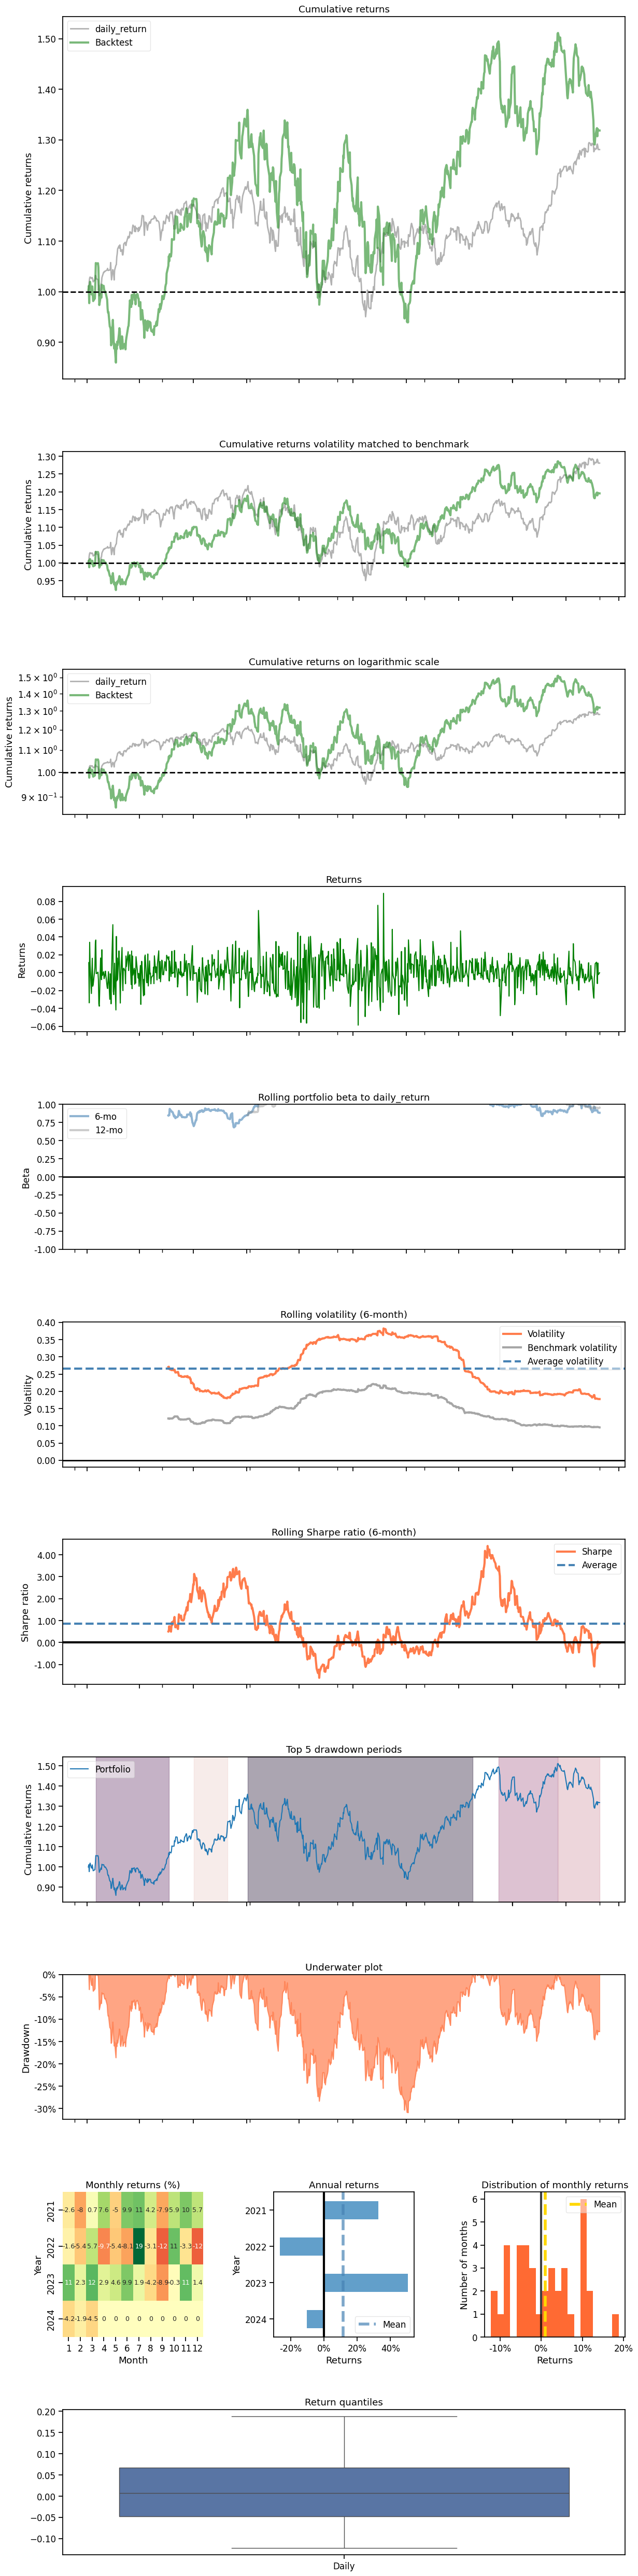

In [79]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(daily_account_value, 
            baseline_ticker = '^DJI', 
            baseline_start = TEST_START_DATE,
            baseline_end = TEST_END_DATE)

### Compare to Buy&Hold Strategy
pass in df_account_value, this information is stored in env class

<a id='6.2'></a>
## 7.2 BackTest with Buy&Hold Strategy

In [188]:
# print(DOW_30_TICKER)
# test_portfolio = DOW_30_TICKER
test_portfolio = ['NKE']
modify_fields = ['open','high','low','close']
used_columns = ['date','close']

In [126]:
# df_stock_test_ = get_baseline(
#         ticker='AXP', 
#         start = TEST_START_DATE,
#         end = TEST_END_DATE)
# df_stock_test_

In [127]:
# for field in modify_fields:
#     df_stock_test_[field] = df_stock_test_[field]/df_stock_test_.iloc[0][field]/len(test_portfolio)
# df_stock_test_ = df_stock_test_[used_columns]

In [189]:
#baseline stats
print("==============Get Baseline Stats===========")
shape = daily_account_value.shape
df_hold_ = pd.DataFrame(0,index=range(shape[0]), columns=range(shape[1]))
df_hold_.columns = used_columns
df_hold_['date'] = daily_account_value.date

for stock in test_portfolio:
    df_stock_ = get_baseline(
        ticker=stock, 
        start = TEST_START_DATE,
        end = TEST_END_DATE)
    # for field in modify_fields:
    if len(df_stock_) < len(df_hold_):
        final_row = df_stock_.iloc[-1]
        new_rows = pd.DataFrame([final_row] * (len(df_hold_) - len(df_stock_)))
        df_stock_ = pd.concat([df_stock_, new_rows], ignore_index=True)
        
        for i in range(0,len(df_stock_) < len(df_hold_)):
            df_stock_.iloc[en(df_stock_)] = df_stock_.iloc[len(df_stock_-1)]
    df_stock_['close'] = df_stock_['close']/df_stock_.iloc[0]['close']/len(test_portfolio)
    df_hold_['close'] = df_hold_.close + df_stock_.close

stats = backtest_stats(df_hold_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (805, 8)
Annual return         -0.091297
Cumulative returns    -0.263764
Annual volatility      0.325662
Sharpe ratio          -0.131990
Calmar ratio          -0.173135
Stability              0.495953
Max drawdown          -0.527314
Omega ratio            0.976443
Sortino ratio         -0.189531
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.973287
Daily value at risk   -0.041200
dtype: float64


The model' calculation encompass the entire timeframe, including non-working days. To address this, we need to determine the most appropriate method to fill up the weekend plots, for example backfilling.

In [131]:
# df_hold_.date = pd.to_datetime(df_hold_['date'])
# df_hold_ = pd.merge(df_account_value_ppo['date'],df_hold_,how='left')
# df_hold_.bfill(inplace=True)
# df_hold_

In [190]:
df_hold = pd.DataFrame()
df_hold['date'] = daily_account_value['date']
df_hold['hold'] = df_hold_['close'] / df_hold_['close'][0] * env_kwargs["initial_amount"]
# print("df_hold: ", df_hold)
# df_dji.to_csv("df_dji.csv")
df_hold = df_hold.set_index(df_hold.columns[0])
print("df_hold: ", df_hold)
# df_hold.to_csv("df_dji+.csv")

# df_account_value.to_csv('df_account_value.csv')

df_hold:                      hold
date                    
2021-01-04  1.000000e+06
2021-01-05  1.008066e+06
2021-01-06  1.016060e+06
2021-01-07  1.034618e+06
2021-01-08  1.044611e+06
...                  ...
2024-03-12  7.402256e+05
2024-03-13  7.489445e+05
2024-03-14  7.408167e+05
2024-03-15  7.362355e+05
2024-03-18  7.362355e+05

[806 rows x 1 columns]


==============Compare to Buy&Hold===========
result:                     stock          hold
date                                  
2021-01-04  1.000000e+06  1.000000e+06
2021-01-05  1.000000e+06  1.008066e+06
2021-01-06  1.006923e+06  1.016060e+06
2021-01-07  1.025313e+06  1.034618e+06
2021-01-08  1.035215e+06  1.044611e+06
...                  ...           ...
2024-03-11  7.363734e+05  7.468756e+05
2024-03-12  7.298178e+05  7.402256e+05
2024-03-13  7.384129e+05  7.489445e+05
2024-03-14  7.304006e+05  7.408167e+05
2024-03-15  7.258845e+05  7.362355e+05

[805 rows x 2 columns]


<Figure size 1500x500 with 0 Axes>

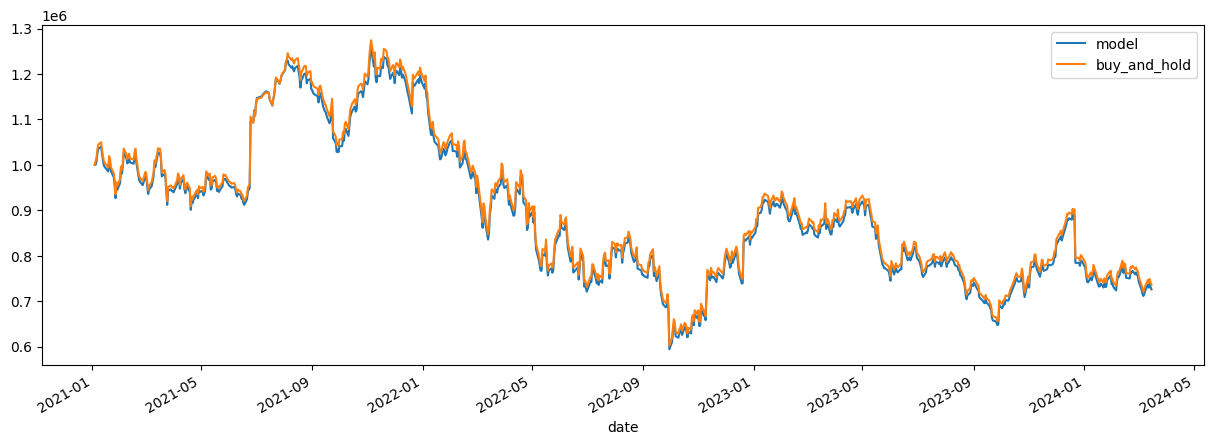

In [191]:
print("==============Compare to Buy&Hold===========")
df_result = pd.DataFrame({'date': df_account_value_ppo['date'], 'stock': df_account_value_ppo['account_value']})
df_result = df_result.set_index('date')

result = pd.DataFrame()
result = pd.merge(df_result, df_hold, left_index=True, right_index=True)
print("result: ", result)
# result.to_csv("result.csv")
result.columns = ['model', 'buy_and_hold']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

<a id='7'></a>
# 8. Save and load model #

<a id='7.1'></a>
## 8.1 Save model

### 8.1.1 Save trained model

In [102]:
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [103]:
model_name = "./"+TRAINED_MODEL_DIR+"/main_dow30_randomTic_discrete_standadized_shortSell_64x3_ppo3_2m_steps"
model_name

'./trained_models/main_dow30_randomTic_discrete_standadized_shortSell_64x3_ppo3_2m_steps'

In [104]:
trained_ppo.save(model_name)

### 8.1.2 Save model as ONNX file

In [74]:
import torch as th
import torch.onnx
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import DDPG
from stable_baselines3.common.policies import BasePolicy
from typing import Tuple

In [72]:
class OnnxableSB3Policy(th.nn.Module):
    def __init__(self, policy: BasePolicy):
        super().__init__()
        self.policy = policy

    def forward(self, observation: th.Tensor) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # NOTE: Preprocessing is included, but postprocessing
        # (clipping/inscaling actions) is not,
        # If needed, you also need to transpose the images so that they are channel first
        # use deterministic=False if you want to export the stochastic policy
        # policy() returns `actions, values, log_prob` for PPO
        return self.policy(observation, deterministic=True)

In [76]:
onnx_policy = OnnxableSB3Policy(trained_ppo.policy)
observation_size = trained_ppo.observation_space.shape
dummy_input = th.randn(1, *observation_size)

# th.onnx.export(
#     onnx_policy,
#     dummy_input,
#     "main_dow30_randomTic_discrete_shortSell_256neu_ppo_4m_steps.onnx",
#     opset_version=17,
#     input_names=["input"],
# )

In [77]:
onnx_policy

OnnxableSB3Policy(
  (policy): ActorCriticPolicy(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (pi_features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (vf_features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (mlp_extractor): MlpExtractor(
      (policy_net): Sequential(
        (0): Linear(in_features=19, out_features=256, bias=True)
        (1): Tanh()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): Tanh()
      )
      (value_net): Sequential(
        (0): Linear(in_features=19, out_features=256, bias=True)
        (1): Tanh()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): Tanh()
      )
    )
    (action_net): Linear(in_features=256, out_features=3, bias=True)
    (value_net): Linear(in_features=256, out_features=1, bias=True)
  )
)

<a id='7.2'></a>
## 8.2 Load model

<a id='7.2.1'></a>
### 8.2.1 Load trained model

In [58]:
from stable_baselines3 import PPO
import os
current_dir = os.getcwd()
print(current_dir)

/Users/admin/Desktop/GameProjects/DataScience/DeepReinforcementLearning/FinRL-Tutorials-master/6-Binhlai_Testing


In [59]:
model_name = "./"+TRAINED_MODEL_DIR+"/main_dow30_randomTic_discrete_standadized_shortSell_64x3_ppo3_2m_steps"
model_name

'./trained_models/main_dow30_randomTic_discrete_standadized_shortSell_64x3_ppo3_2m_steps'

In [60]:
trained_model = PPO.load(model_name)

Continous training based on the previous model at [**Part5. Train DRL Agents**](#5)

In [59]:
# #Establish the training environment using StockTradingEnv() class
# agent = DRLAgent(env = env_train)
# trained_model.env = env_train

In [64]:
# trained_ppo = agent.train_model(model=trained_model, 
#                              tb_log_name='ppo',
#                              total_timesteps=total_training_step)

#### Test loaded model

In [ ]:
test_env = StockTradingEnv(df = trade_data, **env_kwargs)

In [ ]:
test_step = 1000
test_result = []
test_env.reset()
for i in range(0,test_step):
    observation = [test_env.state]
    observation = np.array(observation).astype(np.float32)
    actions, values, log_prob = ort_sess.run(None, {"input": observation})
    result = test_env.step(actions)
    test_result.append(result[1])
    if result[2] == True:
        break

### 8.2.2 Load ONNX model

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

In [ ]:
onnx_path = "all_in_one_ppo.onnx"
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

# # Check that the predictions are the same
# with th.no_grad():
#     print(model.policy(th.as_tensor(observation), deterministic=True))

In [ ]:
observation = np.zeros((1, state_space)).astype(np.float32)
ort_sess = ort.InferenceSession(onnx_path)
actions, values, log_prob = ort_sess.run(None, {"input": observation})
print(actions, values, log_prob)